## Установка и импорт всех библиотек и модулей

In [544]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Работа с данными: предобработка и анализ.
Выведем начальную информацию по набору данных. Заполним пустые значения и заменим строковые значения на числовые для лучшей работы модели. Исключим лишние метрики. Разделим пассажиров по возрастным группам и изучим корелляцию таргета (Survived) с другими показателями.

In [545]:
dataset = pd.read_csv("titanic.csv")
print(dataset.info())

age_med = dataset.Age.median()
max_embarked = dataset.groupby('Embarked').count()['PassengerId']
dataset.Embarked[dataset.Embarked.isnull()] = max_embarked[max_embarked == max_embarked.max()].index[0]

label = LabelEncoder()
dicts = {}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


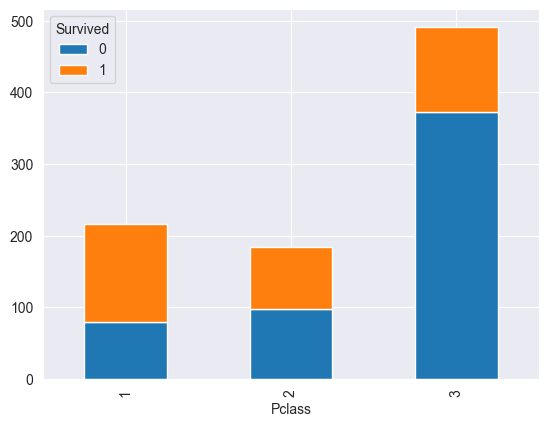

In [546]:
dataset.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)
youngDF = dataset.loc[dataset['Age'] > 18]
oldDF = dataset.loc[dataset['Age'] <= 18]

In [547]:
youngDF.corr(method='pearson', numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.025025,-0.022699,0.041049,-0.030099,0.012967,0.007387
Survived,0.025025,1.000000,-0.381785,0.009912,0.124156,0.060932,0.291697
Pclass,-0.022699,-0.381785,1.000000,-0.358249,-0.164504,-0.017953,-0.541642
Age,0.041049,0.009912,-0.358249,1.000000,-0.013270,0.064012,0.116731
SibSp,-0.030099,0.124156,-0.164504,-0.013270,1.000000,0.263071,0.233582
Parch,0.012967,0.060932,-0.017953,0.064012,0.263071,1.000000,0.213692
Fare,0.007387,0.291697,-0.541642,0.116731,0.233582,0.213692,1.000000


In [548]:
oldDF.corr(method='pearson', numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.048611,-0.092984,0.068023,-0.188624,-0.098788,0.020898
Survived,0.048611,1.000000,-0.422752,-0.239028,-0.355708,0.097627,0.174147
Pclass,-0.092984,-0.422752,1.000000,-0.068641,0.282444,-0.101611,-0.695696
Age,0.068023,-0.239028,-0.068641,1.000000,-0.340685,-0.520813,0.024859
SibSp,-0.188624,-0.355708,0.282444,-0.340685,1.000000,0.465241,0.098891
Parch,-0.098788,0.097627,-0.101611,-0.520813,0.465241,1.000000,0.268733
Fare,0.020898,0.174147,-0.695696,0.024859,0.098891,0.268733,1.000000


<Axes: title={'center': 'Parch'}, xlabel='Parch'>

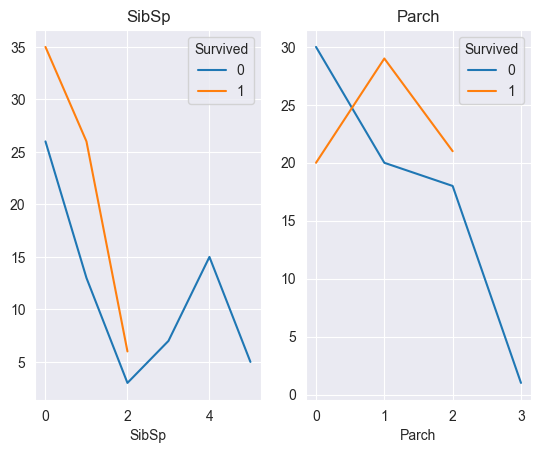

In [549]:
fig, axes = plt.subplots(ncols=2)
oldDF.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(ax=axes[0], title='SibSp')
oldDF.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(ax=axes[1], title='Parch')

Как можем видеть в обоих случаях, вероятность спасения кореллирует с социальным классом. Среди молодых людей до 18 лет наблюдается некоторый уровень связи с ценой билета (чем дороже, тем выше шансы). Также среди взрослых наблюдается корелляция с числом родственников второго порядка (чем их больше, тем меньше шанс выжить).

Проведём аналогичное исследование по социальному классу

In [550]:
firstclassDF = dataset.loc[dataset['Pclass'] == 1]
secondclassDF = dataset.loc[dataset['Pclass'] == 2]
thirdclassDF = dataset.loc[dataset['Pclass'] == 3]

In [551]:
firstclassDF.corr(method='pearson', numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.159824,NaN,-0.003969,-0.055167,-0.026157,-0.026348
Survived,0.159824,1.000000,NaN,-0.267964,0.162276,0.062565,0.190966
Pclass,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,-0.003969,-0.267964,NaN,1.000000,-0.121015,-0.243613,-0.218611
SibSp,-0.055167,0.162276,NaN,-0.121015,1.000000,0.261954,0.259492
Parch,-0.026157,0.062565,NaN,-0.243613,0.261954,1.000000,0.380963
Fare,-0.026348,0.190966,NaN,-0.218611,0.259492,0.380963,1.000000


In [552]:
secondclassDF.corr(method='pearson', numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026030,NaN,0.039077,0.079737,0.077052,0.021281
Survived,-0.026030,1.000000,NaN,-0.273507,0.145340,0.361793,0.098628
Pclass,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,0.039077,-0.273507,NaN,1.000000,-0.210424,-0.300814,-0.197038
SibSp,0.079737,0.145340,NaN,-0.210424,1.000000,0.326626,0.546093
Parch,0.077052,0.361793,NaN,-0.300814,0.326626,1.000000,0.373920
Fare,0.021281,0.098628,NaN,-0.197038,0.546093,0.373920,1.000000


In [553]:
thirdclassDF.corr(method='pearson', numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.096550,NaN,0.034886,-0.080127,-0.014438,0.002053
Survived,-0.096550,1.000000,NaN,-0.202102,-0.073339,0.017257,0.000930
Pclass,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,0.034886,-0.202102,NaN,1.000000,-0.435763,-0.138434,-0.260315
SibSp,-0.080127,-0.073339,NaN,-0.435763,1.000000,0.464733,0.766003
Parch,-0.014438,0.017257,NaN,-0.138434,0.464733,1.000000,0.585265
Fare,0.002053,0.000930,NaN,-0.260315,0.766003,0.585265,1.000000


Как можем видеть, у пассажиров из среднего социального класса выживаемость кореллирует с числом родственников первого порядка

In [554]:
dataset.Age[dataset.Age.isnull()] = dataset.Age.mean()
dataset.Fare[dataset.Fare.isnull()] = dataset.Fare.median()
MaxPassEmbarked = dataset.groupby('Embarked').count()['PassengerId']
dataset.Embarked[dataset.Embarked.isnull()] = MaxPassEmbarked[MaxPassEmbarked == MaxPassEmbarked.max()].index[0]
dataset = dataset.drop(['Name','Ticket','Cabin','PassengerId', 'Embarked'],axis=1)
dataset['Sex'].replace({'male':1,'female':0},inplace=True)

## Работа с готовыми моделями
Обработаем текстовые значения, необходимые для обучения модели (Sex и Embarked) с помощью библиотеки sklearn

In [555]:
target = dataset[['Survived']].to_numpy()
train = dataset.drop(['Survived'], axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.25)

model_knn = KNeighborsClassifier(n_neighbors = 7, p=0.25, algorithm='auto')
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=13, random_state=150, max_features=4, max_depth=11)
gb_model = GradientBoostingClassifier(n_estimators=14, random_state=7, learning_rate=0.5)
mlp_model = MLPClassifier(hidden_layer_sizes=(150,), max_iter=120, random_state=100)
model_dtc = DecisionTreeClassifier(criterion='gini', random_state=1, min_weight_fraction_leaf=0.12)

model_lr.fit(X_train, y_train)
model_dtc.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
mlp_model.fit(X_train, y_train)

y_prob_decision_tree = model_dtc.predict_proba(X_test)[:, 1]
y_prob_logistic = model_lr.predict_proba(X_test)[:, 1]
y_prob_knn = model_knn.predict_proba(X_test)[:, 1]
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
mlp_pred = mlp_model.predict(X_test)

roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)
roc_auc_rf = roc_auc_score(y_test, rf_pred)
roc_auc_gb = roc_auc_score(y_test, gb_pred)
roc_auc_mlp = roc_auc_score(y_test, mlp_pred)
roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')
print(f'ROC AUC of Random Forest: {roc_auc_rf}')
print(f'ROC AUC of Gradient Boosting: {roc_auc_gb}')
print(f'ROC AUC of MLP: {roc_auc_mlp}')

ROC AUC of Logistic Regression: 0.8240963855421688
ROC AUC of Decision Tree: 0.8271944922547332
ROC AUC of K-Nearest Neighbors: 0.8227194492254734
ROC AUC of Random Forest: 0.7987091222030981
ROC AUC of Gradient Boosting: 0.7806368330464716
ROC AUC of MLP: 0.7531841652323581


In [556]:
#К-блочная кросс валидация
def cross_valid(model, target, train, name):
    kf = KFold(n_splits=5)

    accuracies = []
    for train_index, test_index in kf.split(target):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = target[train_index], target[test_index]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

    print("Средняя точность " + name + f': {np.mean(accuracies)}')

cross_valid(model_lr, target, train, "Logistic Regression")
cross_valid(model_dtc, target, train, "Decision Tree")
cross_valid(model_knn, target, train, "K-Nearest Neighbors")
cross_valid(rf_model, target, train, "Random Forest")
cross_valid(gb_model, target, train, "Gradient Boosting")
cross_valid(mlp_model, target, train, "MLP")

Средняя точность Logistic Regression: 0.7766618542464379
Средняя точность Decision Tree: 0.7732785135898562
Средняя точность K-Nearest Neighbors: 0.8013997865796247
Средняя точность Random Forest: 0.814889209716904
Средняя точность Gradient Boosting: 0.8181972255351202
Средняя точность MLP: 0.7890527901575545


## Итоги
Лучшими моделями для решения проблемы выживших на Титанике является Random Forest и Gradient Boosting